In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
import cv2
from math import pi, ceil

path = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"

In [84]:
def getImage(mode=0):
    img = cv2.imread(path,mode)
    return cv2.resize(img,(640,480))

def applyBlur(img, k=9):
    return cv2.GaussianBlur(img,(k,k),0)

def otsu(img,block=81,offset=0.3):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def adaptativeThresh(img,block=121,offset=0):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def fillHoles(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    thresh_filled = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    color = 255
    for i in range(len(contours)):
        cv2.drawContours(thresh_filled, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    return thresh_filled

def connectedComponents(thresh):
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    labeled_img_rgb = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
    return labeled_img_rgb, numLabels, labels, stats, centroids


def erode(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.erode(src, element)
    
def dilate(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.dilate(src, element)




def getPrincipalComponents(img):
    # Connected components with stats.
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)

    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])
    
    img2 = np.zeros(output.shape, dtype='uint8')
    img2[output == max_label] = 255
    return img2

In [99]:
MIN_CELL_AREA = 500
MAX_CELL_AREA = 2300



def markCells(img, mask, minArea=MIN_CELL_AREA, maxArea=MAX_CELL_AREA, cells=(255,255,255), size=5):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)

    for i in range(1, numLabels):
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        #get area
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        #print(minArea, area, maxArea)
        if minArea < area < maxArea:
            cv2.circle(img, (int(cX), int(cY)), size, (0,0,0), -1)
            cv2.circle(img, (int(cX), int(cY)), size-1, cells, -1)
        
        if maxArea < area:
            est = ceil(area/maxArea)
            cv2.circle(img, (int(cX)-7, int(cY)), size, (0,0,0), -1)
            cv2.circle(img, (int(cX)-7, int(cY)), size-1, cells, -1)
            cv2.putText(img, str(est), (int(cX), int(cY)+4), cv2.FONT_HERSHEY_SIMPLEX,
                        .5, (0,0,0), 6, cv2.LINE_AA)
            cv2.putText(img, str(est), (int(cX), int(cY)+5), cv2.FONT_HERSHEY_SIMPLEX,
                        .5, (255,255,255), 2, cv2.LINE_AA)
            
            cv2.rectangle(img, (x,y), (x+w,y+h), cells, 1)
 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def breakBigGroups(mask, minArea = MIN_CELL_AREA, maxArea=MAX_CELL_AREA):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        cut = cut.copy()

        if maxArea < area:
            cut_bk = cut.copy()
            cut = getPrincipalComponents(cut)

            #remove the group from original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask[ cell_on_original_size == 255 ] = 0

            #work on group
            #cut = cv2.erode(cut, kernel, iterations=1)
            cut = erosion(cut,15)
            cut = dilatation(cut,11)

            #return the eroded and marked group to original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask += cell_on_original_size
    
    return mask


In [105]:
def random_color():
    color = tuple(np.random.randint(256, size=3))
    if (color[0] < 100 and color[1] < 100 and color[2] < 100):
        return random_color()
    elif (color[0] > 230 and color[1] > 230 and color[2] > 230):
        return random_color()
    else:
        return color

def shuffleColors(img):

    shape = img.shape
    reshapedImg = img.reshape(1,shape[0]*shape[1],3)[0]
    colors = np.unique(reshapedImg, axis=0)
    colors = np.delete(colors,0,axis=0)
    
    labeled_img_rgb3 = img.copy()

    for color in colors:
        newColor = random_color()

        red, green, blue = labeled_img_rgb3.T 
        selected_color = (red == color[0]) & (green == color[1]) & (blue == color[2])
        labeled_img_rgb3[selected_color.T] = newColor
    return labeled_img_rgb3


def colorize(img):
    labeled_rgb, numLabels, labels, stats, centroids = connectedComponents(img)
    return shuffleColors(labeled_rgb)

In [126]:
def hsvMask(img, fromColor=(110,0,0),toColor=(150,255,255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, fromColor, toColor)
    mask_dilated = mask.copy()
    #erode
    kernel = np.ones((3, 3), np.uint8)
    mask_dilated = cv2.erode(mask_dilated, kernel)
    #dilate
    kernel = np.ones((15, 15), np.uint8)
    mask_dilated = cv2.dilate(mask_dilated, kernel)

    return mask, mask_dilated

def removeParasites(img,mask):
    img[mask == 255] = 0
    img = erode(img,2)
    img = dilate(img,2)
    return img

def markParasites(img, mask, cell_mask, external_infection_color=(0, 220, 240), inside_infection_color=(171,0,171)):
    labeled_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)
    
    _, _, _, cell_stats, _ = connectedComponents(cell_mask)
    
    #remove the parasites from cell mask
    #cell_mask[mask==255] = 0
    #cell_mask = fillHoles(cell_mask)
    
    for i in range(1, numLabels):
        area = stats[i, cv2.CC_STAT_AREA]
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        (cX, cY) = centroids[i]
        
        color = external_infection_color
        for cell_stat in cell_stats:
            cellArea  = cell_stat[cv2.CC_STAT_AREA]
            cellX = cell_stat[cv2.CC_STAT_LEFT]
            cellY = cell_stat[cv2.CC_STAT_TOP]
            cellW = cell_stat[cv2.CC_STAT_WIDTH]
            cellH = cell_stat[cv2.CC_STAT_HEIGHT]
            
            if MIN_CELL_AREA < cellArea < MAX_CELL_AREA*4:
                if cellX < cX < cellX+cellW and cellY < cY < cellY+cellH:
                    color = inside_infection_color
                    cv2.rectangle(img, (cellX,cellY), (cellX+cellW,cellY+cellH), (0,255,0), 1)
                    break
        
        
#         area_median = np.median(cell_mask[int(cY)-3:int(cY)+3,int(cX)-3:int(cX)+3])
#         #if cell_mask[int(cY),int(cX)] == 255:
#         if area_median > 0:
#             color = inside_infection_color
#         else:
#             color = external_infection_color
#             cv2.circle(img, (int(cX), int(cY)), 3, (255,0,0), -1)
        
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 1)
        
    return img


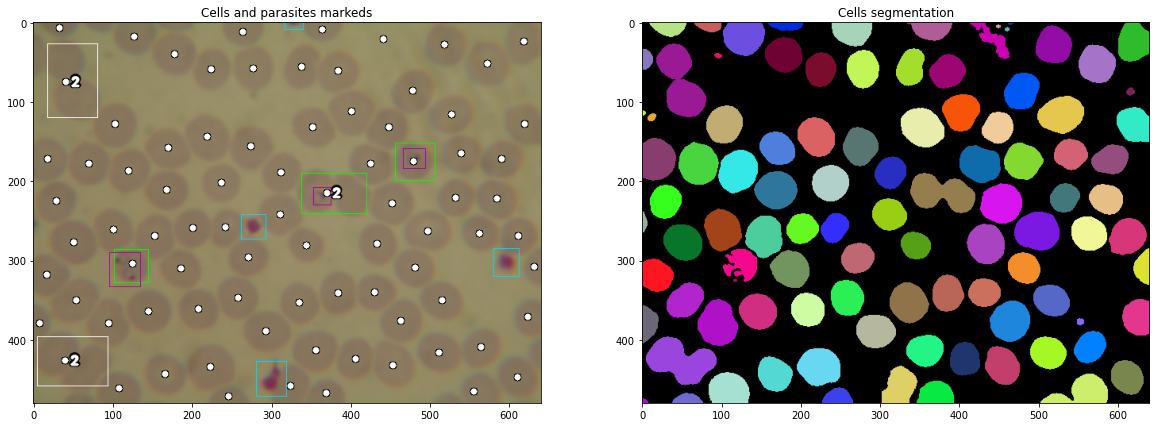

In [129]:

#read in grayscale
imgGS = getImage()
#read in colors
img = getImage(mode=1)

#apply blur
imgGS = applyBlur(imgGS)
img = applyBlur(img)

#otsu adaptative
cell_mask = otsu(imgGS)

#hsv mask
par_mask, par_mask_dilated = hsvMask(img)

#remove parasites from otsu
cell_mask = removeParasites(cell_mask,par_mask)

#fill holes
cell_mask = fillHoles(cell_mask)

#break gorup of cells
cell_mask = breakBigGroups(cell_mask)

#colorize the cells
cell_mask_colored = colorize(cell_mask)

#mark
img = markCells(img, cell_mask)
img = markParasites(img, par_mask_dilated, cell_mask)

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Cells and parasites markeds")
ax[1].imshow(cell_mask_colored, cmap='gray')
ax[1].set_title("Cells segmentation")
plt.show()